In [1]:
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.jet_finding import *
from jetstream_hugo.clustering import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
jet_pos_da = exp.jet_position_as_da()
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)

In [3]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "6h"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "6h"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "6h"),
    ).drop("year", "start", "end")
    return [seasons[season].explode().sort() for season in seasons.columns]

In [4]:
dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/3")
exp_wind = Experiment(dh)
centers_kmeans, labels_kmeans = exp_wind.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
summer_daily = summer.filter(summer.dt.hour() == 0)
da_summer = dh.da.sel(time=summer.to_numpy())
dh_summer = DataHandler.from_basepath_and_da(exp_wind.path.parent, da_summer, save_da=True)
exp_summer = Experiment(dh_summer)
nx, ny, n_pca = 4, 4, 200
net, centers, labels = exp_summer.som_cluster(
    nx,
    ny,
    n_pca,
    sigma=1.5,
    sigmaN=1e-5,
    train_kwargs=dict(num_epochs=20),
    init="pca",
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates

ds_center_path = exp_summer.path.joinpath(f"uvs_som_{nx}_{ny}_{n_pca}_pbc_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds_center_summer = labels_to_centers(labels, ds)
    ds_center_summer.to_netcdf(ds_center_path)
else:
    ds_center_summer = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_summer.da.time, "cluster": np.arange(net.n_nodes)})

all_jets_center_summer = find_all_jets(xarray_to_polars(ds_center_summer), base_s_thresh=22, alignment_thresh=0.5)
all_jets_center_summer = is_polar_gmix(all_jets_center_summer, ("lon", "lat", "lev"), n_components=2, n_init=100, mode="year")

100%|██████████| 16/16 [00:00<00:00, 468.12it/s]


In [28]:
from sklearn.metrics import pairwise_distances
dists = pairwise_distances(net.weights)
sigma = np.quantile(dists[dists > 0].flatten(), 0.05)
spells = get_persistent_spell_times_from_som(labels, dists, sigma, 32, nt_before=20, nojune=True, daily=True)

labels_daily = labels.sel(time=labels.time.dt.hour == 0)
mask_daily = labels_to_mask(labels_daily)
jets_daily = all_jets_one_df.filter(pl.col("time").is_in(summer_daily))

spells_per_cluster = spells.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
numbering = [f"{numb + 1}, {spells_per_cluster[int(numb), 'len']}" for numb in range(net.n_nodes)]

props_as_df_anoms = compute_anomalies_pl(props_as_df, ("jet", ), 31, True)
props_masked = mask_from_spells_pl(spells, props_as_df_anoms)
props_masked_ = props_masked.group_by(pl.col("value"), pl.col("relative_index"), pl.col("jet")).mean().rename({"value": "cluster"})
indexer = pl.Series("cluster", np.arange(net.n_nodes)).to_frame().join(props_masked[:, ["jet", "relative_index"]].unique(("jet", "relative_index")), how="cross").sort("cluster", "jet", "relative_index")
props_masked_ = indexer.join(props_masked_, how="left", on=["cluster", "jet", "relative_index"])

# natural coordinate composites

In [79]:
da_T = open_da(
    "ERA5", "surf", "t2m", "dailymean", "all", None, -100, 60, 0, 90, "all",
)
da_T = compute(da_T.sel(time=summer_daily.to_numpy()))
da_tp = open_da(
    "ERA5", "surf", "tp", "dailysum", "all", None, -100, 60, 0, 90, "all",
)
da_tp = compute(da_tp.sel(time=summer_daily.to_numpy()))

da_apvs = open_da("ERA5", "thetalev", "apvs", "dailyany", "all", None, -100, 60, 0, 90)
da_apvs = compute(da_apvs.sel(time=summer_daily.to_numpy()))
da_cpvs = open_da("ERA5", "thetalev", "cpvs", "dailyany", "all", None, -100, 60, 0, 90)
da_cpvs = compute(da_cpvs.sel(time=summer_daily.to_numpy()))

In [80]:
def symmetrize_p(pvals: xr.DataArray | np.ndarray, direction: int, q: float) -> np.ndarray:
    if direction == 0:
        return np.amin([pvals * 2, (1 - pvals) * 2], axis=0) < q
    if direction == 1:
        return np.asarray(pvals) > 1 - q
    return np.asarray(pvals) < q


def plot_all_relative_composites(jets, times, variable_dict, n_bootstraps: int = 50):
    figs = []
    for varname, props in variable_dict.items():
        if len(props) == 3:
            da, nlevels, cmap = props
            clim = None
        else:
            da, clim, nlevels, cmap = props
        hatch = "xxx" if varname == "tp" else "xx"
        
        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(jets, times, da, n_bootstraps=n_bootstraps, clim=clim)
        try:
            to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
            pvals = jets_during_spells_with_interp_norm_ds["pvals"]
        except KeyError:
            to_plot = jets_during_spells_with_interp_norm_ds
            
        direction = infer_direction(to_plot)
        symmetric = direction == 0

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(to_plot.quantile(0.01), to_plot.quantile(0.99))
        norm = BoundaryNorm(levels, cmap.N)
        
        axes[0].pcolormesh(to_plot.norm_index, to_plot.n, to_plot[0].T, norm=norm, cmap=cmap)
        filter_ = symmetrize_p(pvals[0].T, direction, 0.05)
        axes[0].pcolor(pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.)
        
        axes[1].pcolormesh(to_plot.norm_index, to_plot.n, to_plot[1].T, norm=norm, cmap=cmap)
        filter_ = symmetrize_p(pvals[1].T, direction, 0.05)
        axes[1].pcolor(pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.)

        fig.colorbar(ScalarMappable(norm, cmap), ax=axes, spacing="proportional")
        figs.append(fig)
    return figs

clim_T = xr.open_dataarray(exp.path.joinpath("t2m_relative_clim.nc"))
clim_tp = xr.open_dataarray(exp.path.joinpath("tp_relative_clim.nc"))
clim_apvs = xr.open_dataarray(exp.path.joinpath("apvs_relative_clim.nc"))
clim_cpvs = xr.open_dataarray(exp.path.joinpath("cpvs_relative_clim.nc"))

variable_dict = {
    "t2m": [da_T, clim_T, 8, colormaps.BlWhRe],
    "tp": [da_tp, clim_tp, 15, colormaps.precip4_diff_19lev],
    "APVS": [da_apvs, clim_apvs, 7, colormaps.curl],
    "CPVS": [da_cpvs, clim_cpvs, 7, colormaps.curl],
}

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

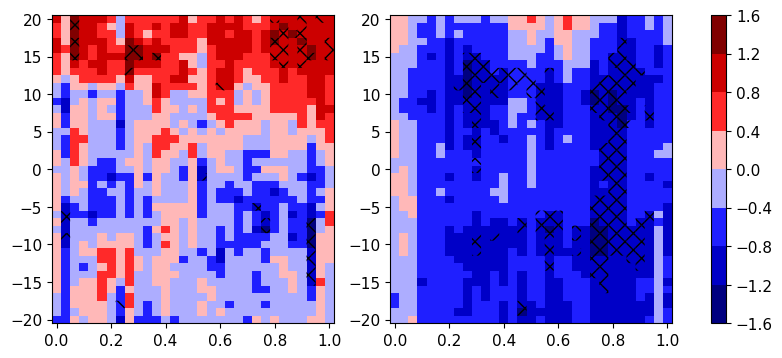

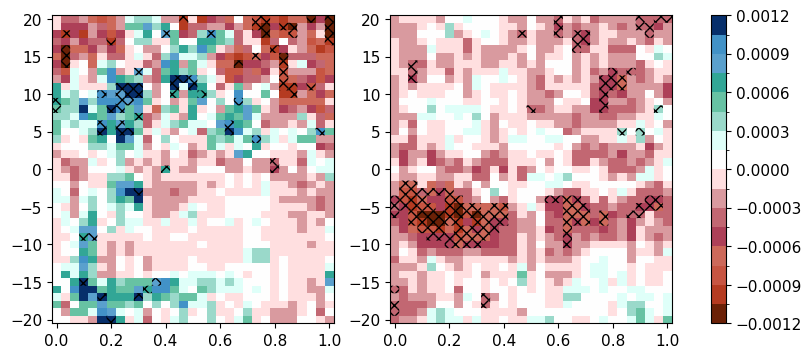

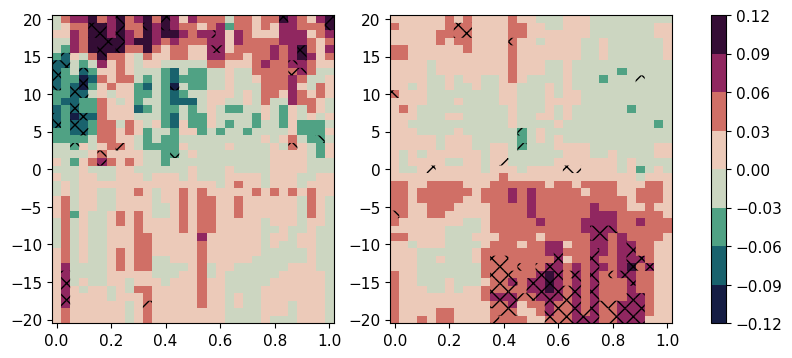

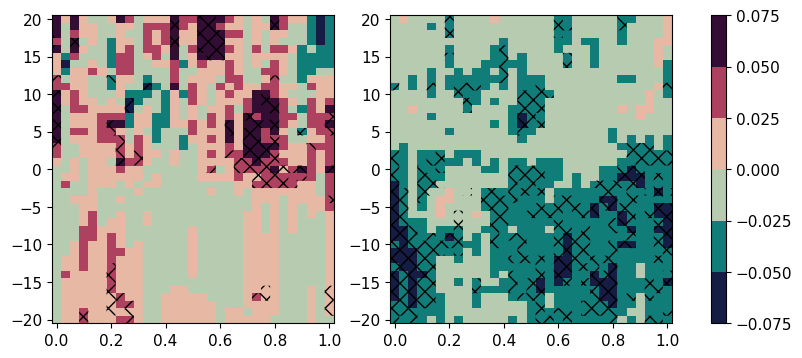

In [81]:
spells_som = spells.filter(pl.col("value") == 5)
spells_som = subset_around_onset(spells_som, around_onset=datetime.timedelta(days=1))

plot_all_relative_composites(jets_daily, spells_som, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

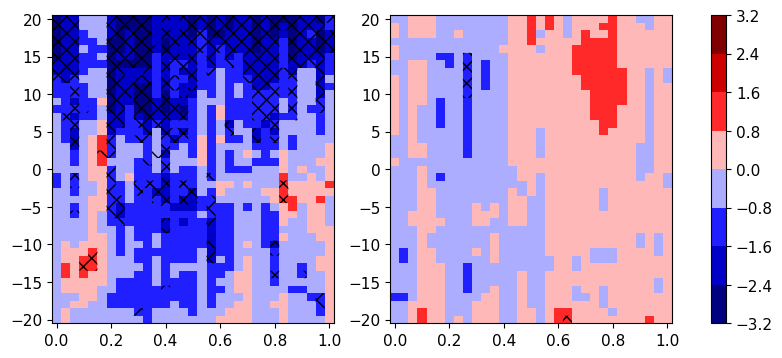

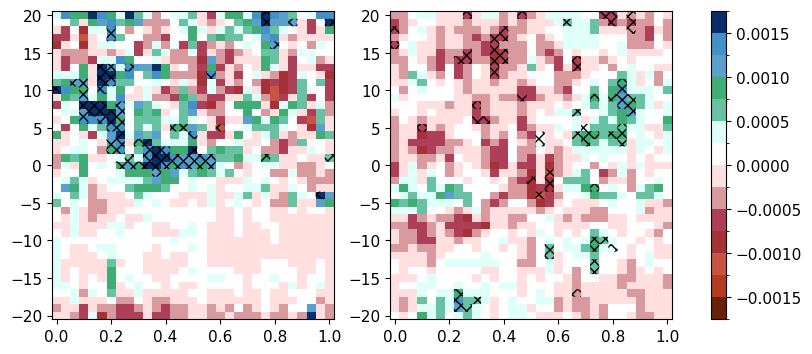

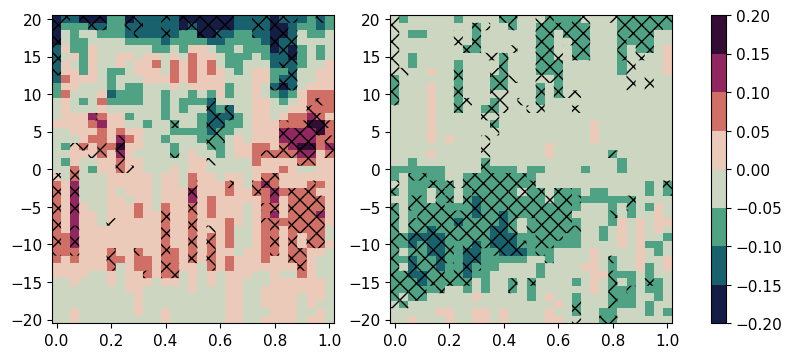

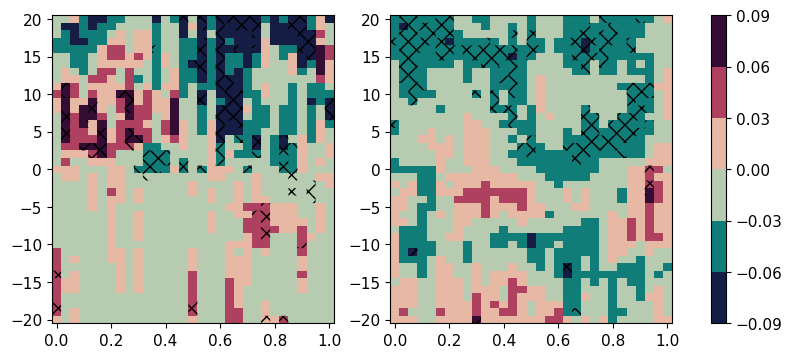

In [82]:
spells_som = spells.filter(pl.col("value") == 6)
spells_som = subset_around_onset(spells_som, around_onset=datetime.timedelta(days=1))

plot_all_relative_composites(jets_daily, spells_som, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

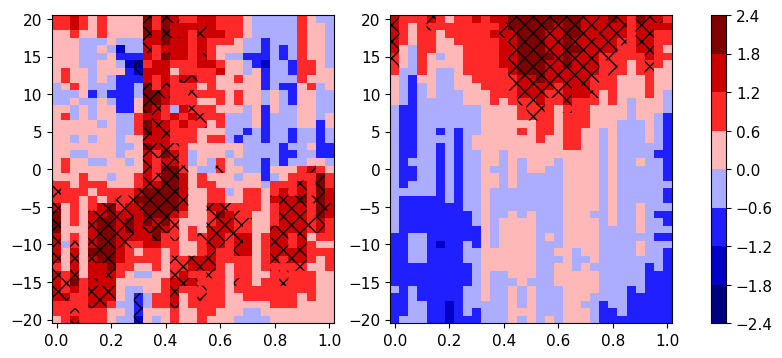

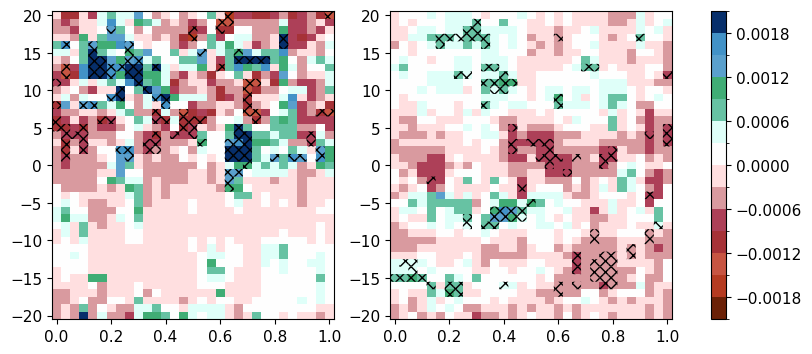

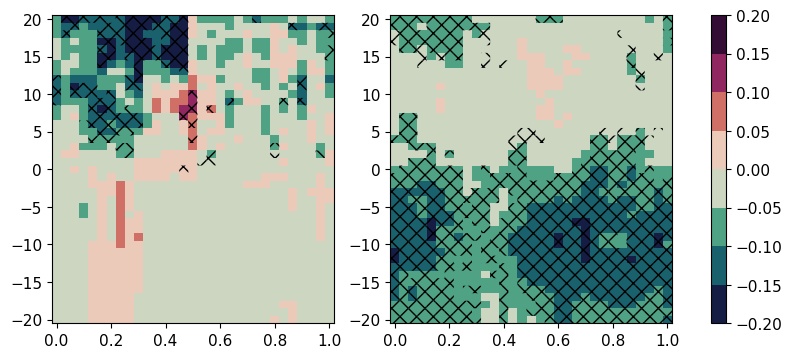

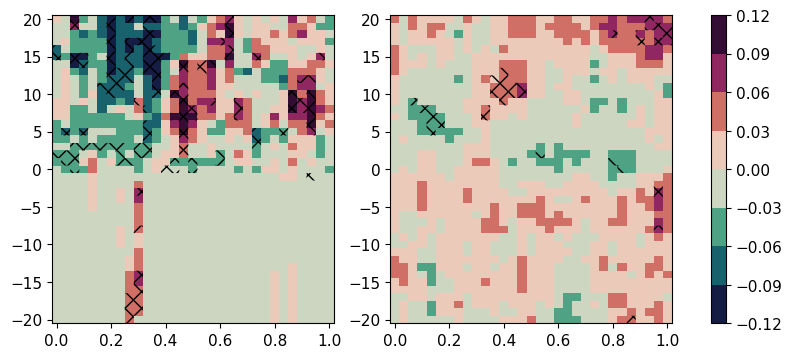

In [83]:
spells_som = spells.filter(pl.col("value") == 7)
spells_som = subset_around_onset(spells_som, around_onset=datetime.timedelta(days=1))

plot_all_relative_composites(jets_daily, spells_som, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

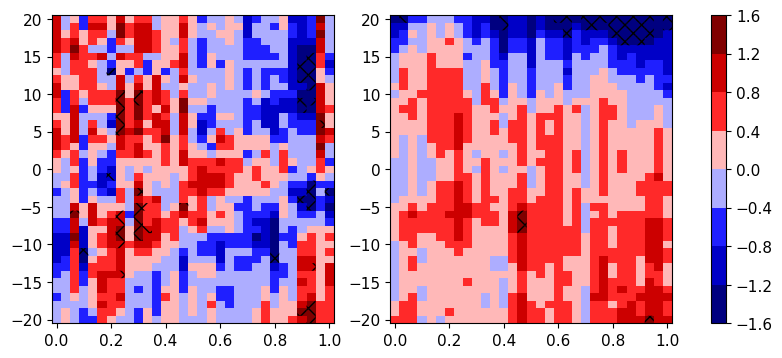

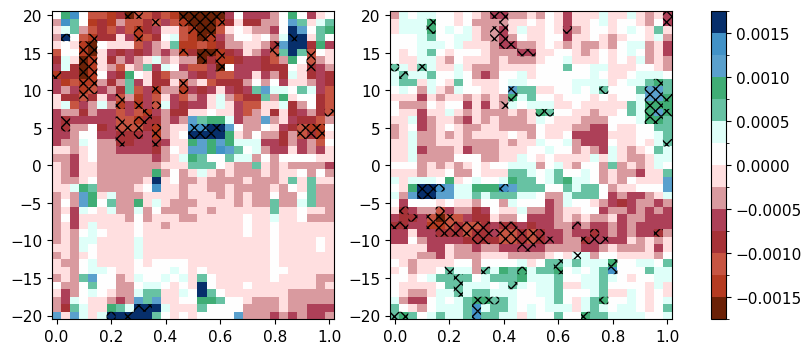

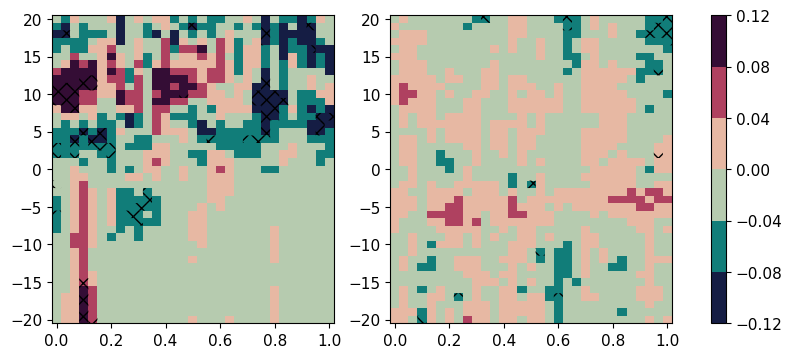

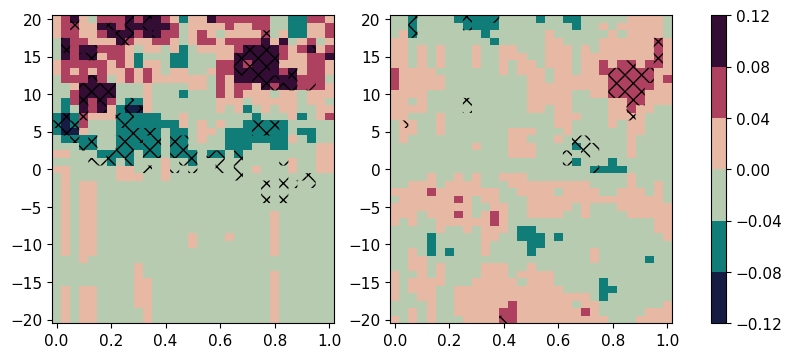

In [84]:
spells_som = spells.filter(pl.col("value") == 8)
spells_som = subset_around_onset(spells_som, around_onset=datetime.timedelta(days=1))

plot_all_relative_composites(jets_daily, spells_som, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

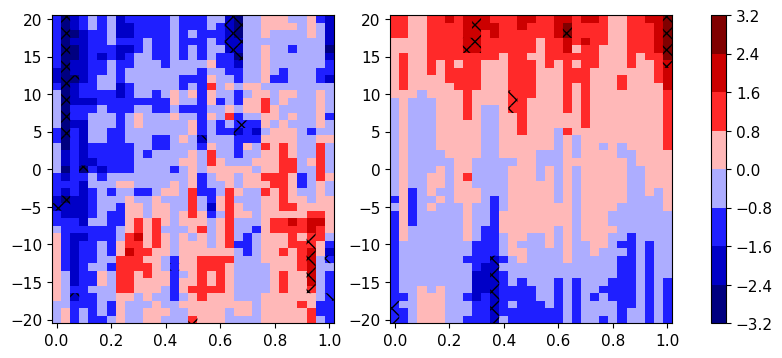

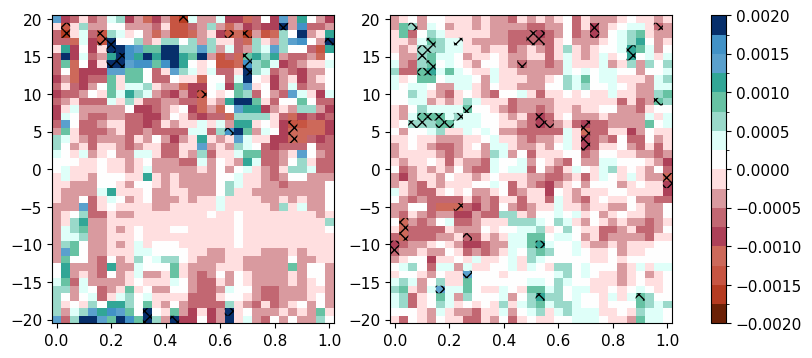

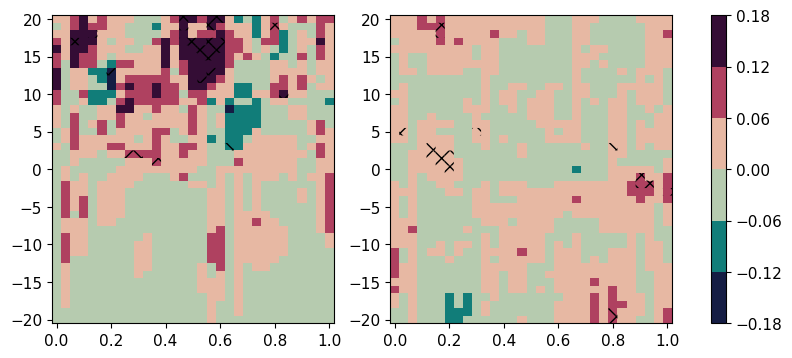

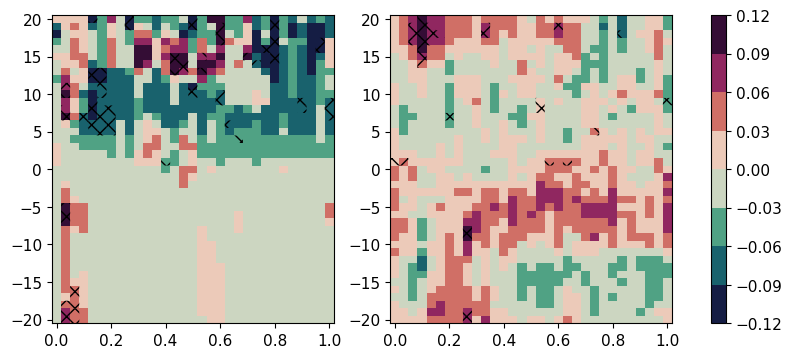

In [85]:
spells_som = spells.filter(pl.col("value") == 9)
spells_som = subset_around_onset(spells_som, around_onset=datetime.timedelta(days=1))

plot_all_relative_composites(jets_daily, spells_som, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

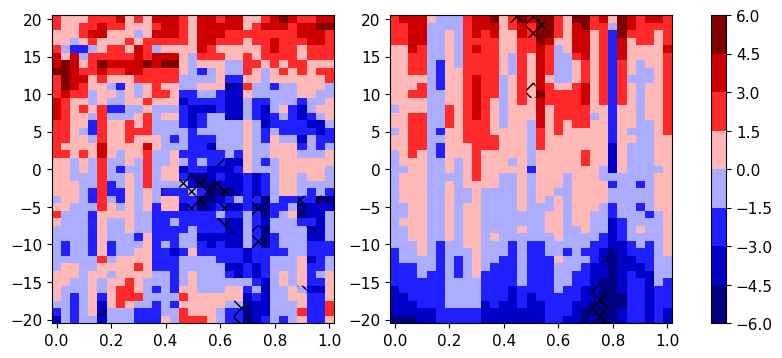

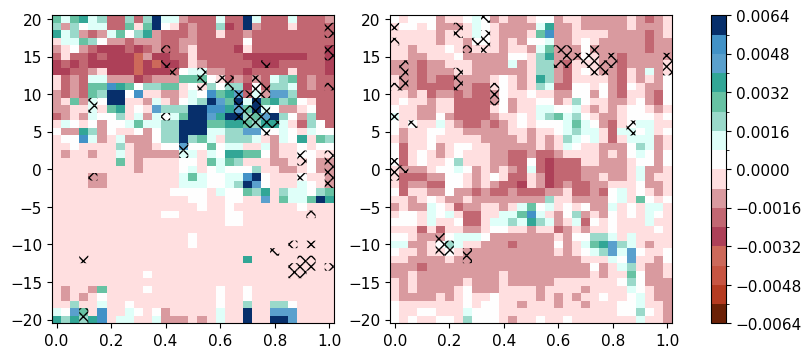

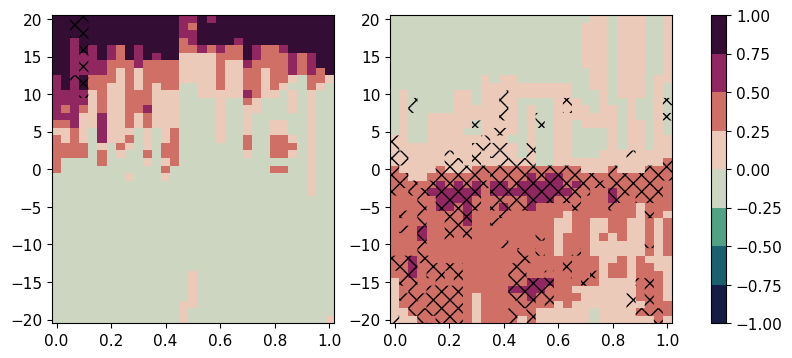

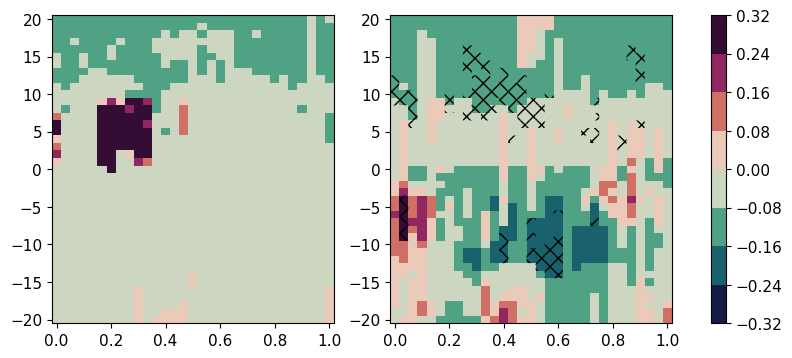

In [86]:
spells_som = spells.filter(pl.col("value") == 10)
spells_som = subset_around_onset(spells_som, around_onset=datetime.timedelta(days=1))

plot_all_relative_composites(jets_daily, spells_som, variable_dict, 50)

# real space composites

In [30]:
da_tp = open_da(
    "ERA5", "surf", "tp", "dailysum", "all", None, *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_tp = da_tp.sel(time=summer_daily.to_numpy())
da_T = open_da(
    "ERA5", "surf", "t2m", "dailymean", "all", None, *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_T = da_T.sel(time=summer_daily.to_numpy())
da_apvs = open_da(
    "ERA5", "thetalev", "apvs", "dailyany", "all", None, *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_apvs = da_apvs.sel(time=summer_daily.to_numpy())
da_cpvs = open_da(
    "ERA5", "thetalev", "cpvs", "dailyany", "all", None, *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_cpvs = da_cpvs.sel(time=summer_daily.to_numpy())

## masked jets

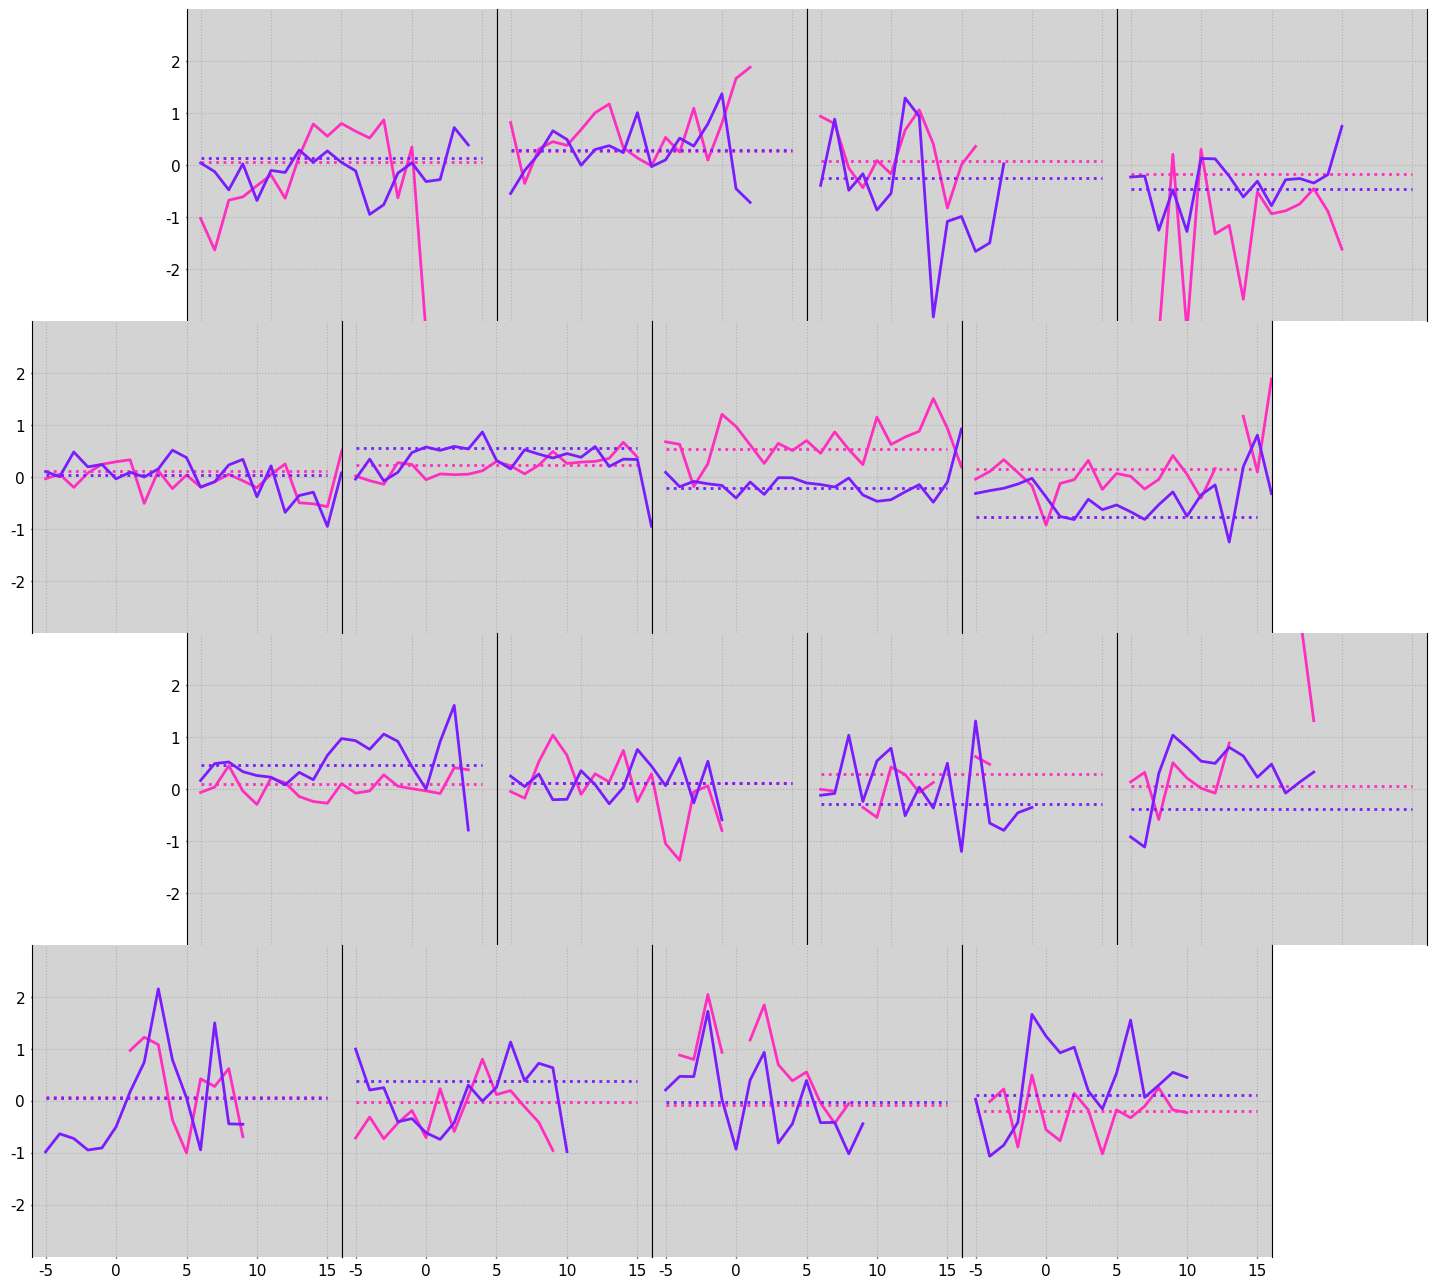

In [31]:
fig, axes = honeycomb_panel(
    4, 4, .9
)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "mean_lat"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
    ax.spines[["top", "bottom"]].set_visible(False)
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 16])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)

In [ ]:
ds_summer = ds.sel(time=summer_daily.to_numpy())
ds_summer = compute(ds_summer, progress_flag=True)

In [ ]:
uvs_masked = mask_from_spells_pl(spells, ds_summer)

In [ ]:
uvs_masked_per_cluster = uvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = uvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
uvs_masked_per_cluster = uvs_masked_per_cluster.sel(cluster=indexer)
uvs_masked_per_cluster = uvs_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))
uvs_masked_per_cluster.loc[{"cluster": to_zero}] = 0.

In [53]:
jets_masked = find_all_jets(xarray_to_polars(uvs_masked_per_cluster), base_s_thresh=0.75)

100%|██████████| 448/448 [00:01<00:00, 287.02it/s]


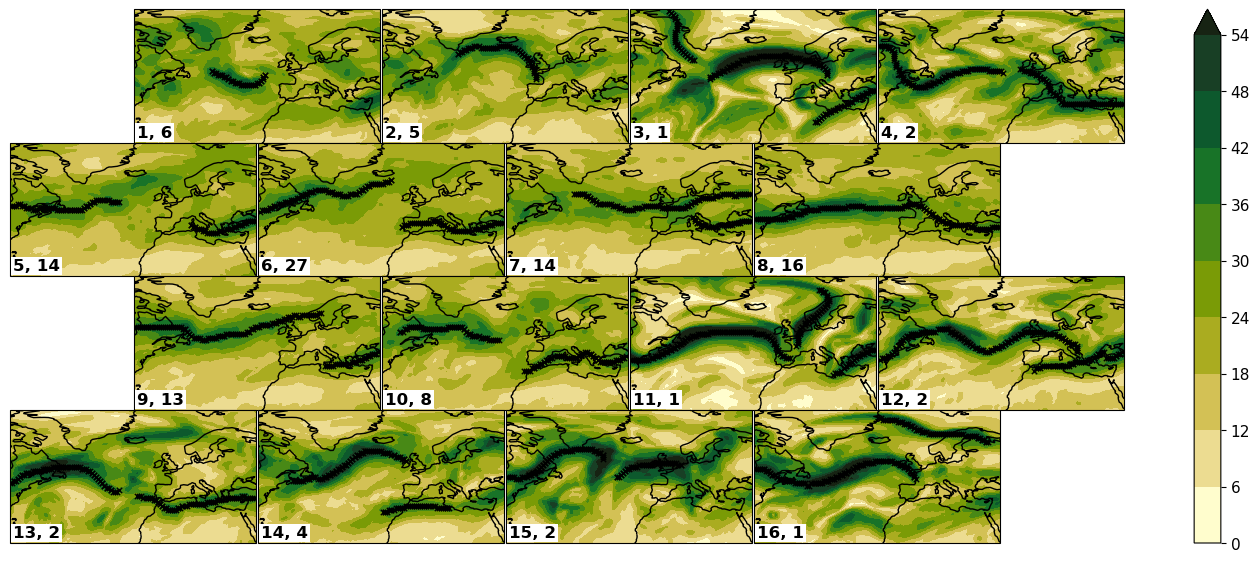

In [56]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(uvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(uvs_masked_per_cluster["s"].sel(relative_index=0), cmap=colormaps.speed, levels=9, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=15, c="black", marker="x")
# for i in range(net.n_nodes):
#     jets = all_jets_center_summer.filter(pl.col("cluster") == i)
#     for j, jet in jets.group_by("jet ID", maintain_order=True):
#         lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
#         axes[i].scatter(lo, la, color="gray", lw=1, s=15, marker="+")

## temp

In [ ]:
da_T = compute(da_T, progress_flag=True)

100%|██████████| 16/16 [00:00<00:00, 439.81it/s]


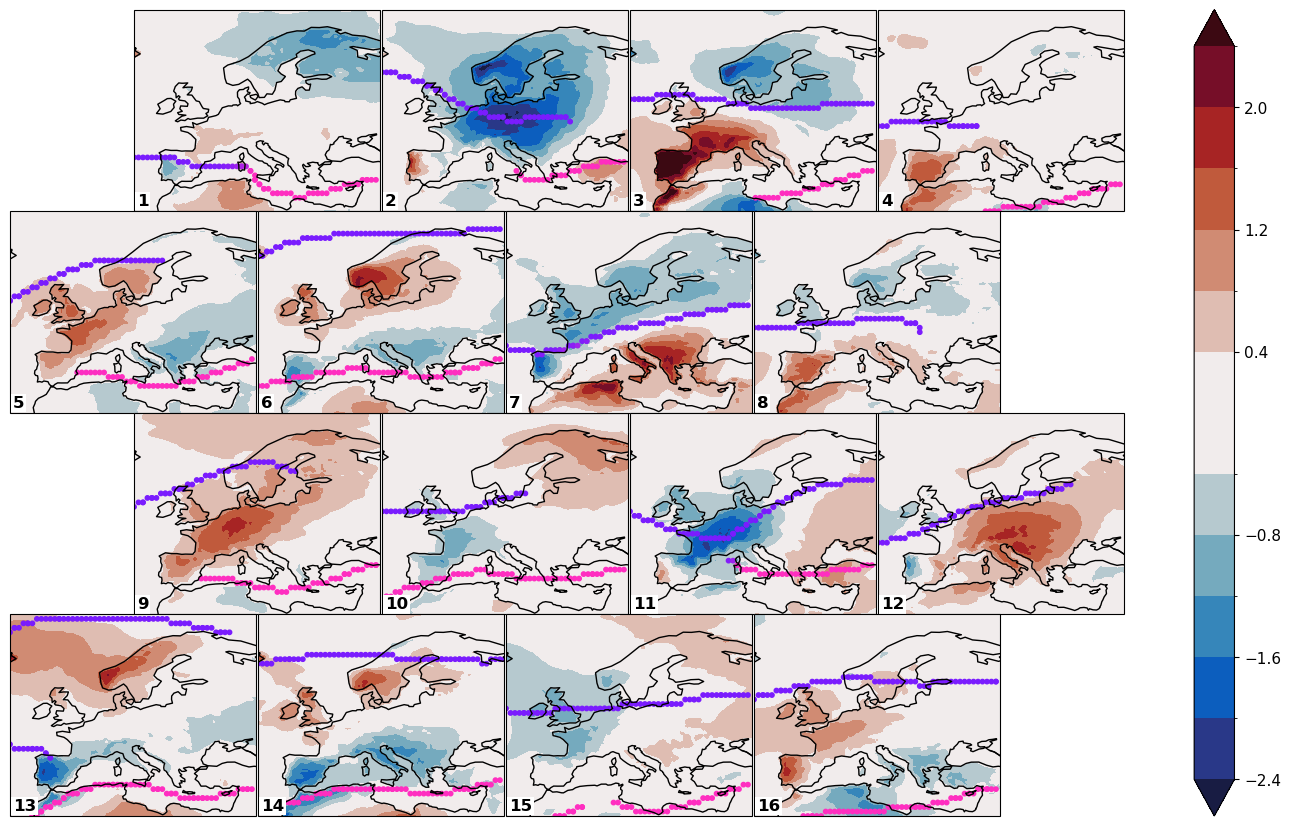

In [37]:
da_T_europe = extract(da_T, "all", None, -15, 40, 30, 75)
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_T_europe), numbering=True)
_ = clu.add_any_contour_from_mask(da_T_europe, mask_daily, cmap=colormaps.balance, levels=12, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [38]:
T_masked = mask_from_spells_pl(spells, da_T)

In [39]:
T_masked_per_cluster = T_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = T_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
T_masked_per_cluster = T_masked_per_cluster.sel(cluster=indexer)
T_masked_per_cluster[to_zero, ...] = 0.
T_masked_per_cluster = T_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

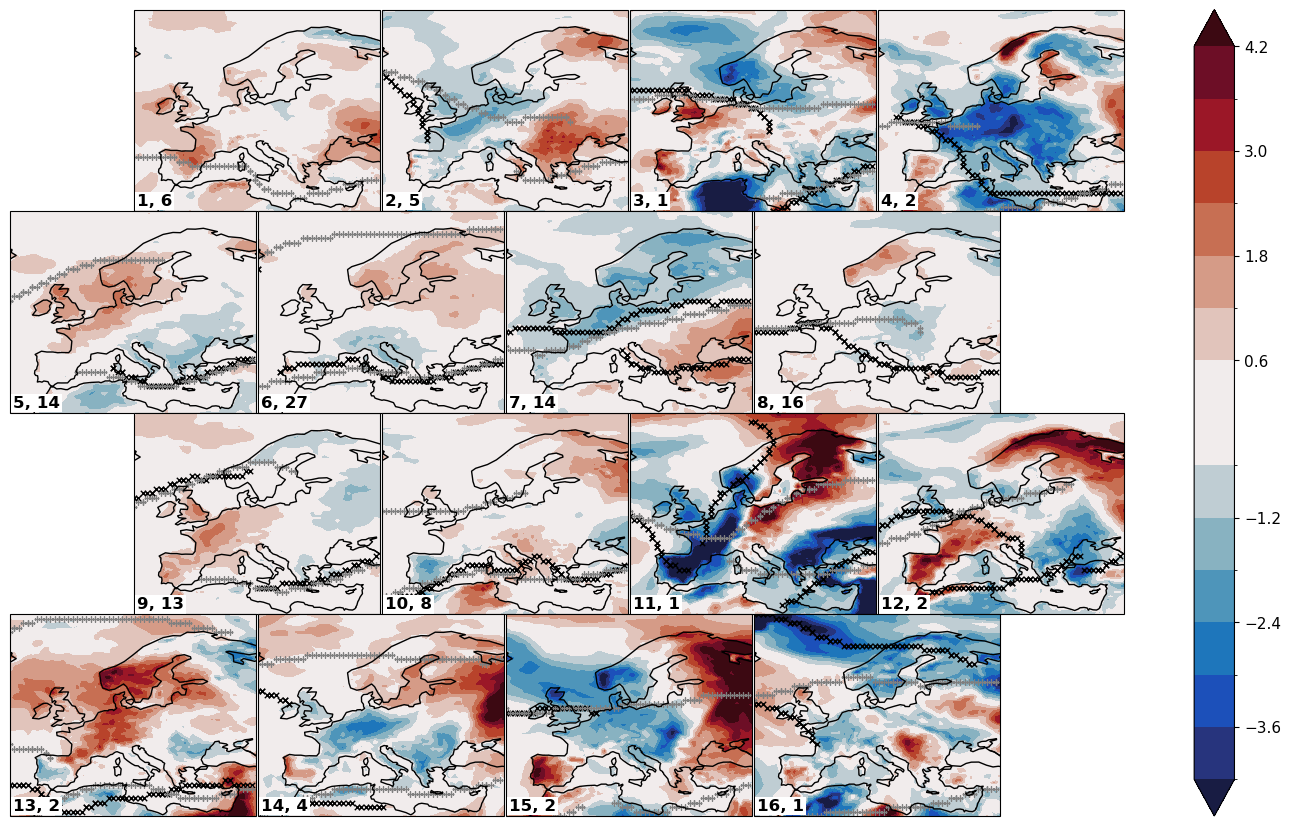

In [54]:
T_masked_per_cluster_europe = extract(T_masked_per_cluster, "all", None, -15, 40, 30, 75)

clu = Clusterplot(4, 4, honeycomb=True, region=get_region(T_masked_per_cluster_europe), numbering=numbering)
_ = clu.add_contourf(T_masked_per_cluster_europe.sel(relative_index=0), cmap=colormaps.balance, levels=13, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=15, c="black", marker="x")
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, color="gray", lw=1, s=15, marker="+")

## precip

In [57]:
da_tp = compute(da_tp, progress_flag=True)

[########################################] | 100% Completed | 38.47 s


100%|██████████| 16/16 [00:00<00:00, 36.41it/s]


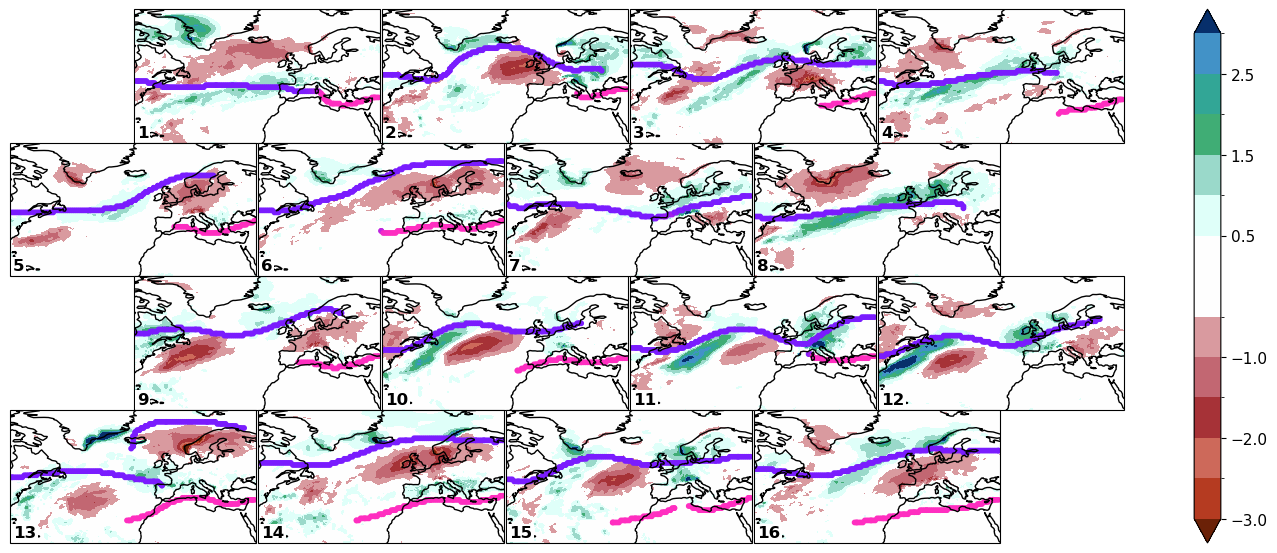

In [58]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_tp), numbering=True)
_ = clu.add_any_contour_from_mask(da_tp * 1000, mask_daily, cmap=colormaps.precip4_diff_19lev, levels=12, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [59]:
tp_masked = mask_from_spells_pl(spells, da_tp)

In [60]:
tp_masked_per_cluster = tp_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = tp_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
tp_masked_per_cluster = tp_masked_per_cluster.sel(cluster=indexer)
tp_masked_per_cluster[to_zero, ...] = 0.
tp_masked_per_cluster = tp_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

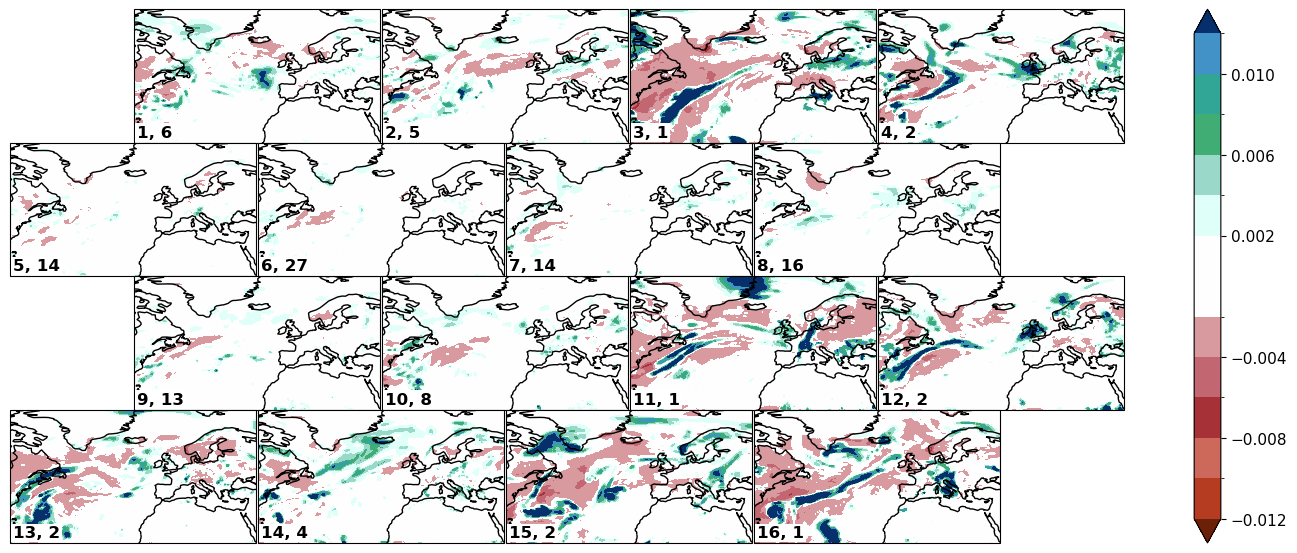

In [61]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(tp_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(tp_masked_per_cluster.sel(relative_index=0), cmap=colormaps.precip4_diff_19lev, levels=13, q=1-1e-2)

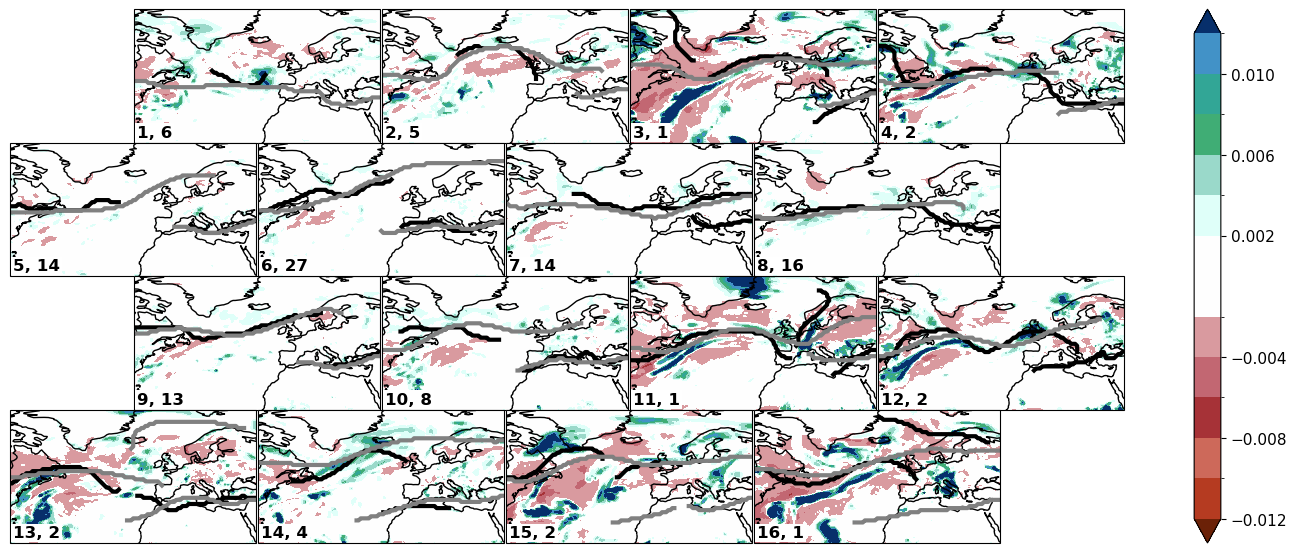

In [62]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(tp_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(tp_masked_per_cluster.sel(relative_index=0), cmap=colormaps.precip4_diff_19lev, levels=13, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].plot(lo, la, lw=3, c="black")
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].plot(lo, la, color="gray", lw=3)

## aPVS

In [63]:
da_apvs = compute(da_apvs, progress_flag=True)

[########################################] | 100% Completed | 101.30 s


100%|██████████| 16/16 [00:00<00:00, 37.35it/s]


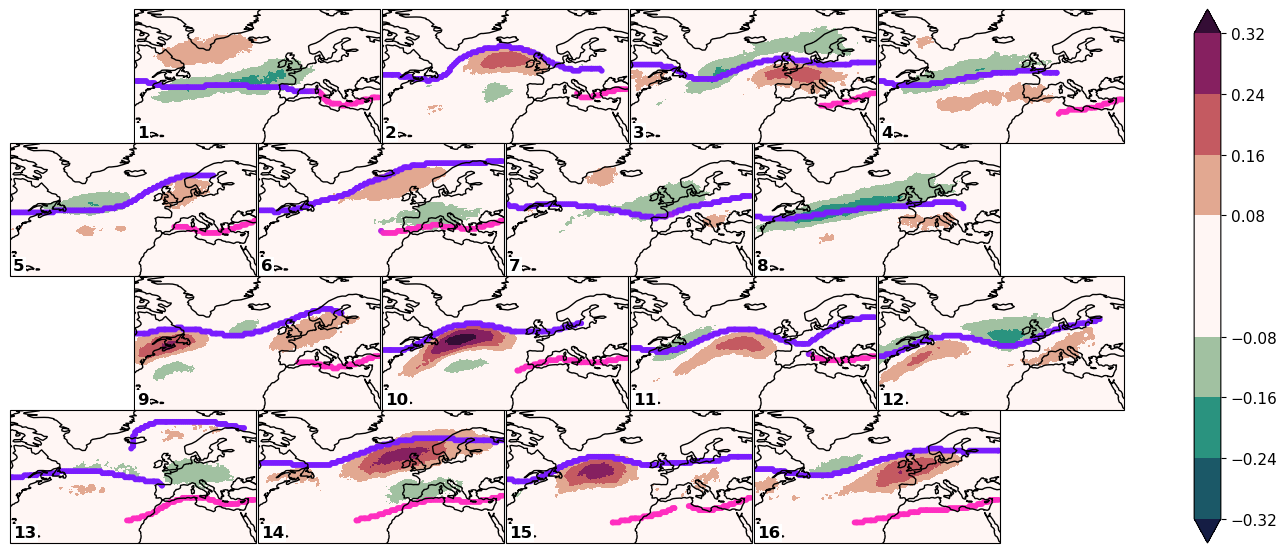

In [74]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_apvs), numbering=True)
_ = clu.add_any_contour_from_mask(da_apvs, mask_daily, cmap=colormaps.curl, levels=7, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [65]:
apvs_masked = mask_from_spells_pl(spells, da_apvs)

In [66]:
apvs_masked_per_cluster = apvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = apvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
apvs_masked_per_cluster = apvs_masked_per_cluster.sel(cluster=indexer)
apvs_masked_per_cluster[to_zero, ...] = 0.
apvs_masked_per_cluster = apvs_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

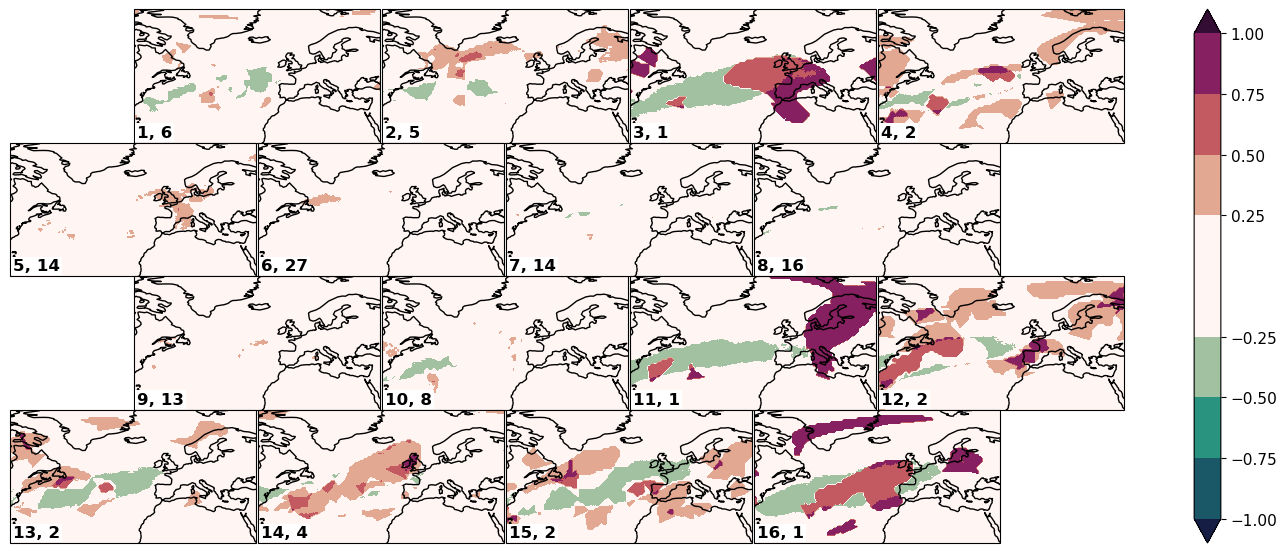

In [75]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(apvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(apvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.curl, levels=7, q=1-1e-2)

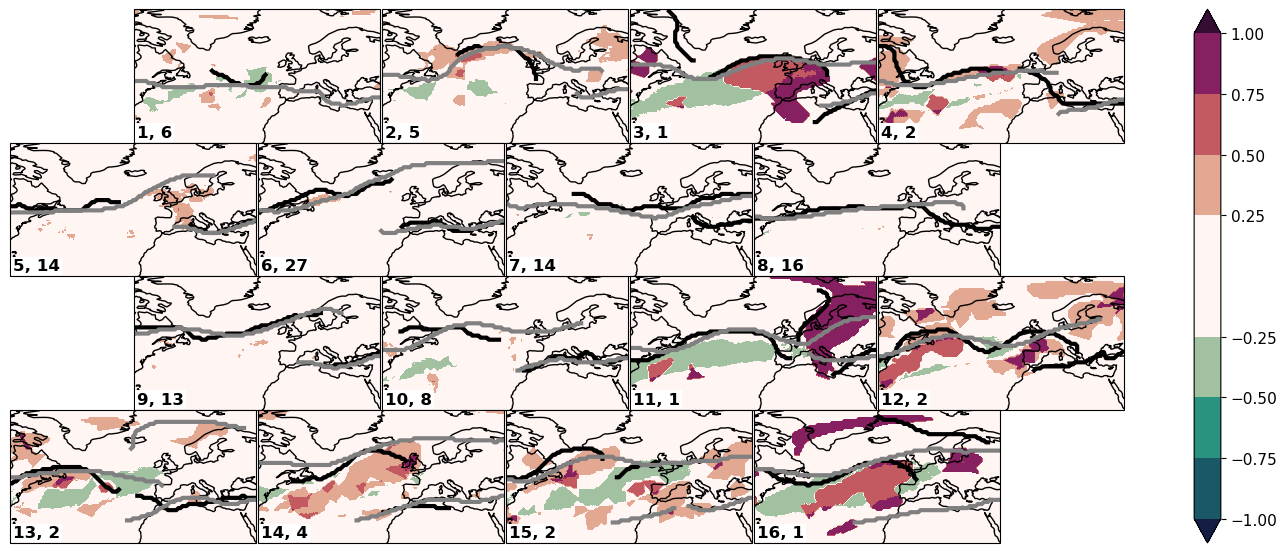

In [76]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(apvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(apvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.curl, levels=7, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].plot(lo, la, lw=3, c="black")
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].plot(lo, la, color="gray", lw=3)

## cPVS

In [69]:
da_cpvs = compute(da_cpvs, progress_flag=True)

[########################################] | 100% Completed | 89.82 s


100%|██████████| 16/16 [00:00<00:00, 37.45it/s]


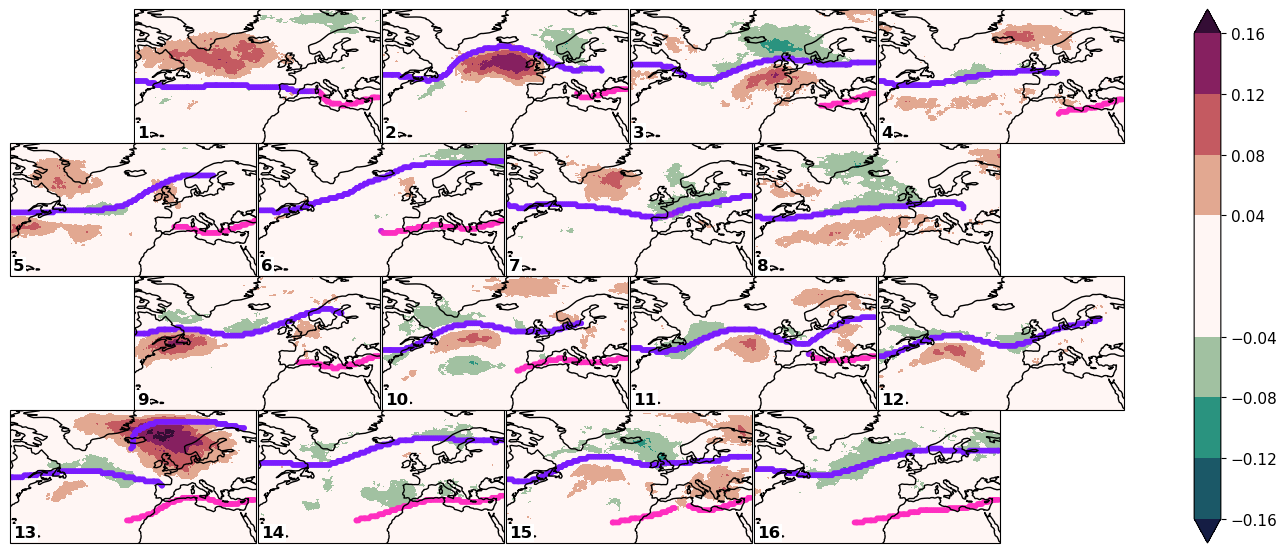

In [78]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_cpvs), numbering=True)
_ = clu.add_any_contour_from_mask(da_cpvs, mask_daily, cmap=colormaps.curl, levels=9, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [71]:
cpvs_masked = mask_from_spells_pl(spells, da_cpvs)

In [72]:
cpvs_masked_per_cluster = cpvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = cpvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
cpvs_masked_per_cluster = cpvs_masked_per_cluster.sel(cluster=indexer)
cpvs_masked_per_cluster[to_zero, ...] = 0.
cpvs_masked_per_cluster = cpvs_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

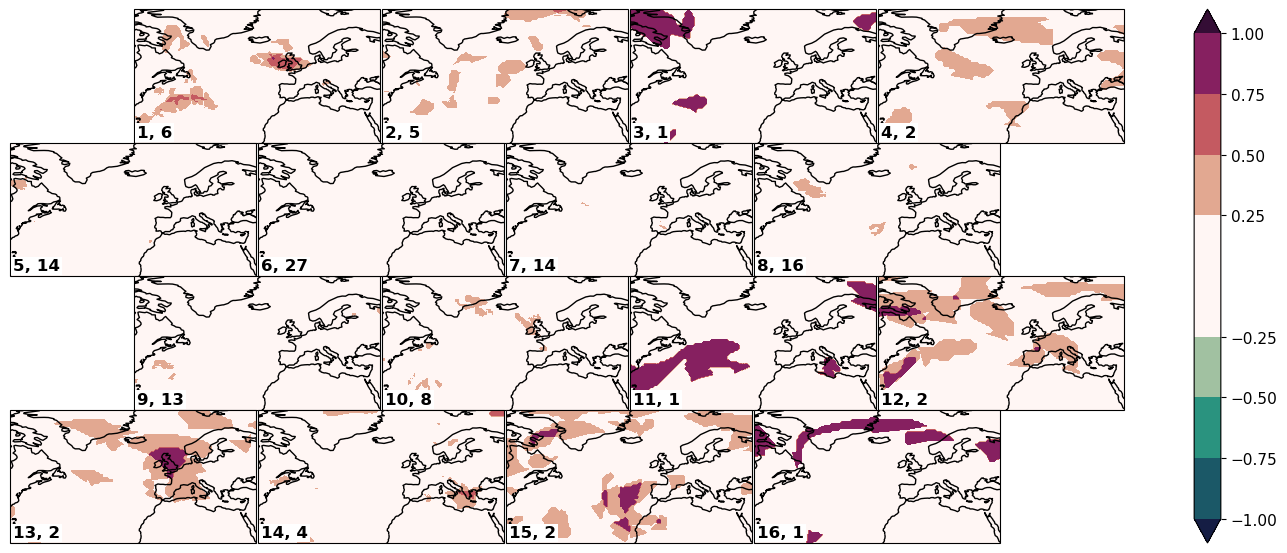

In [73]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(cpvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(cpvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.curl, levels=7, q=1-1e-2)

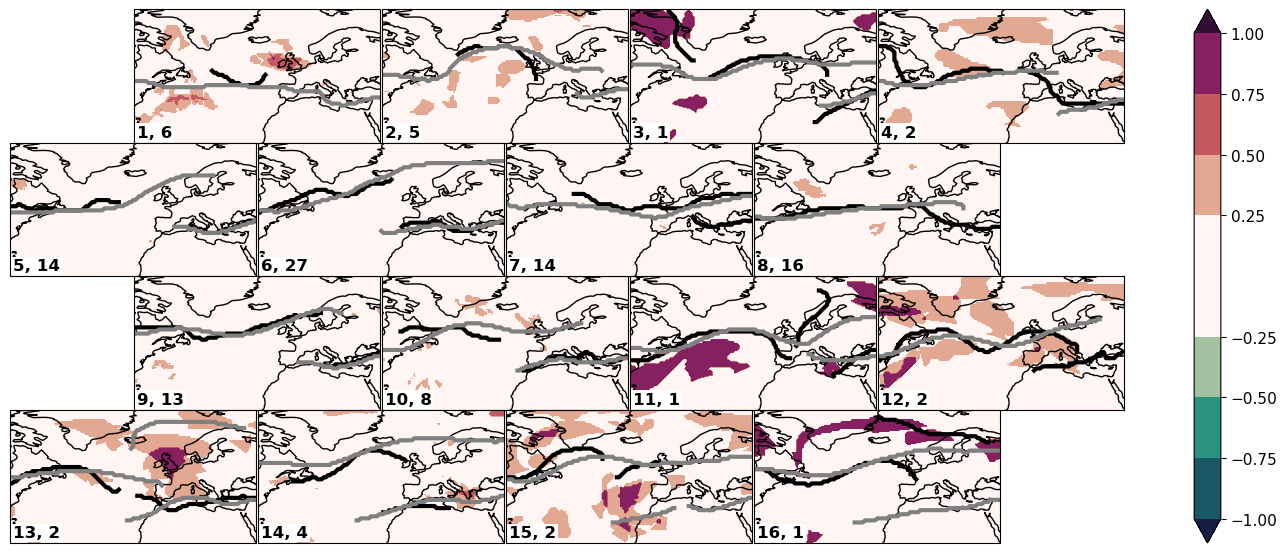

In [77]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(cpvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(cpvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.curl, levels=7, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].plot(lo, la, lw=3, c="black")
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].plot(lo, la, color="gray", lw=3)